In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
torch.set_default_tensor_type(torch.cuda.FloatTensor)
torch.backends.cudnn.benchmark = True
device = "cuda:0" if torch.cuda.is_available() else "cpu"

/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# boiler plate code from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
transform = transforms.Compose( # dont really want to normalize here
     [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32
num_valid = 5000

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                          shuffle=False)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
valid, test = torch.utils.data.random_split(testset, [num_valid, 10000-num_valid], 
                                            generator=torch.Generator(device="cuda").manual_seed(4))
testloader = torch.utils.data.DataLoader(torch.utils.data.Subset(testset, valid.indices),
                                         batch_size=batch_size, shuffle=False)
validloader = torch.utils.data.DataLoader(torch.utils.data.Subset(testset, test.indices), 
                                         batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
class BasicResNet(nn.Module):
    def __init__(self, conv_layers, num_classes, img_shape, groups=1):
        super().__init__()
        self.conv_layers1 = []  # entry into residual block 
        self.conv_layers2 = []  # https://arxiv.org/pdf/1512.03385.pdf Figure 3
        self.batch_norms1 = []
        self.batch_norms2 = []
        self.is_resid = []
        channels = img_shape[-1]
        img_size = img_shape[0]
        for l in conv_layers:  # (out_channels, kernel_size, stride) is each l
            if l[2] == 2: # stride
                pad_type = "valid"
                img_size = (img_size-l[1])//l[2] + 1 # https://arxiv.org/pdf/1603.07285.pdf
            else:
                pad_type = "same"
            if isinstance(l[0], float):
                l[0] = int(l[0])
                l[0] -= l[0] % groups # ensure divisble by groups
            self.is_resid.append(l[2] == 1 and channels == l[0])
            self.conv_layers1.append(nn.Conv2d(channels, l[0], l[1], stride=l[2], padding=pad_type, groups=groups))
            channels = l[0]
            self.final_num_logits = channels * img_size * img_size 
            self.batch_norms1.append(nn.BatchNorm2d(channels))
            self.batch_norms2.append(nn.BatchNorm2d(channels))
            self.conv_layers2.append(nn.Conv2d(channels, channels, l[1], padding=pad_type, groups=groups))
        self.conv_layers1 = nn.ModuleList(self.conv_layers1)
        self.conv_layers2 = nn.ModuleList(self.conv_layers1)
        self.batch_norms1 = nn.ModuleList(self.batch_norms1)
        self.batch_norms2 = nn.ModuleList(self.batch_norms2)

        self.fully_connected1 = nn.Linear(self.final_num_logits, 1000)
        self.fully_connected2 = nn.Linear(1000, num_classes)

    def forward(self, x):
        network_iter = zip(self.conv_layers1, self.conv_layers2, self.batch_norms1, self.batch_norms2, self.is_resid)
        for conv1, conv2, batch_norm1, batch_norm2, is_resid in network_iter:
            x_conv1 = F.relu(batch_norm1(conv1(x)))
            x_conv2 = F.relu(batch_norm2(conv2(x)))
            if is_resid:
                x = x + x_conv2  # residual block
            else:
                x = x_conv2  # dimension increasing block
        x = torch.flatten(x, 1)
        x = F.relu(self.fully_connected1(x))
        x = self.fully_connected2(x)
        return x    

    def num_params(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
    
    def save_model_state_dict(self, path):
        torch.save(self.state_dict(), path)
    
    def load_model_state_dict(self, path):
        self.load_state_dict(torch.load(path))

In [4]:
def correct_num(pred_logits, labels):
    pred_probabilities = F.softmax(pred_logits)
    classifications = torch.argmax(pred_probabilities, 1)
    correct = (labels == classifications).sum()
    return correct

def train(net, optimizer, loss, epochs):
    va_losses = []
    tr_losses = []
    va_accuracies = []
    for epoch in range(epochs):
        epoch_tr_loss = 0.0
        for i, (imgs, labels) in tqdm(enumerate(trainloader)):
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(imgs)
            batch_loss = loss(outputs, labels)
            epoch_tr_loss += batch_loss.item()
            batch_loss.backward()
            optimizer.step()
        epoch_va_loss = 0.0
        epoch_va_correct = 0
        for i, (imgs, labels) in enumerate(validloader):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = net(imgs)
            epoch_va_loss += loss(outputs, labels).item()
            epoch_va_correct += correct_num(outputs, labels).item()
        epoch_va_accuracy = epoch_va_correct/num_valid
        print(f'Epoch {epoch + 1}: va_loss: {epoch_va_loss}, va_accuracy: {epoch_va_accuracy}, tr_loss: {epoch_tr_loss}')
        va_losses.append(epoch_va_loss)
        tr_losses.append(epoch_tr_loss)
        va_accuracies.append(epoch_va_accuracy)
    return va_losses, va_accuracies, tr_losses

In [42]:
basic_res_net = BasicResNet([[64, 7, 1],  # num_channels (input and output), kernel_size, stride
                             [64, 3, 1],
                             [128, 3, 1],
                             [128, 3, 1],
                             [128, 3, 2],
                             [128, 3, 2],
                             [256, 3, 1],
                             [256, 3, 1],
                             [256, 3, 1],
                             [256, 3, 1],
                             [512, 3, 1],
                             [512, 3, 1],
                             [512, 3, 2]], 10, [32, 32, 3])
loss_func = nn.CrossEntropyLoss()
optim = torch.optim.Adam(basic_res_net.parameters())
print(basic_res_net.num_params())

13160002


In [ ]:
results = train(basic_res_net, optim, loss_func, 200)

1563it [00:48, 32.21it/s]
/tmp/ipykernel_31281/3641332645.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_probabilities = F.softmax(pred_logits)


Epoch 1: va_loss: 219.28263598680496, va_accuracy: 0.498, tr_loss: 2601.904141485691


1563it [00:48, 32.37it/s]


Epoch 2: va_loss: 170.87214541435242, va_accuracy: 0.6086, tr_loss: 1978.5076427459717


1563it [00:48, 32.28it/s]


Epoch 3: va_loss: 140.67084285616875, va_accuracy: 0.6836, tr_loss: 1541.0156547427177


1563it [00:48, 32.18it/s]


Epoch 4: va_loss: 123.89411672949791, va_accuracy: 0.7268, tr_loss: 1226.7315624654293


1563it [00:48, 32.25it/s]


Epoch 5: va_loss: 119.96676640212536, va_accuracy: 0.7388, tr_loss: 976.0534102320671


1563it [00:48, 32.16it/s]


Epoch 6: va_loss: 122.20824956893921, va_accuracy: 0.7476, tr_loss: 767.1690935194492


1563it [00:48, 32.00it/s]


Epoch 7: va_loss: 125.37723229825497, va_accuracy: 0.7564, tr_loss: 588.3447615578771


1563it [00:48, 32.01it/s]


Epoch 8: va_loss: 136.12186022102833, va_accuracy: 0.7648, tr_loss: 447.57429456710815


1563it [00:48, 32.19it/s]


Epoch 9: va_loss: 143.89341631531715, va_accuracy: 0.7678, tr_loss: 338.84214414376765


1563it [00:48, 32.20it/s]


Epoch 10: va_loss: 158.00323078036308, va_accuracy: 0.766, tr_loss: 254.92197279445827


1563it [00:48, 32.06it/s]


Epoch 11: va_loss: 167.38598585128784, va_accuracy: 0.7732, tr_loss: 207.6031345189549


1563it [00:48, 32.11it/s]


Epoch 12: va_loss: 170.28354680538177, va_accuracy: 0.776, tr_loss: 169.92513556871563


1563it [00:48, 32.24it/s]


Epoch 13: va_loss: 174.8556013405323, va_accuracy: 0.783, tr_loss: 136.22198831522837


1563it [00:48, 32.20it/s]


Epoch 14: va_loss: 178.00787484645844, va_accuracy: 0.7768, tr_loss: 130.39177776232827


1563it [00:48, 32.15it/s]


Epoch 15: va_loss: 189.02006325125694, va_accuracy: 0.7826, tr_loss: 104.25171626869997


1563it [00:48, 32.25it/s]


Epoch 16: va_loss: 183.33366890251637, va_accuracy: 0.7804, tr_loss: 102.45445612445474


1563it [00:48, 32.09it/s]


Epoch 17: va_loss: 189.21947060525417, va_accuracy: 0.787, tr_loss: 89.25787103635957


1563it [00:48, 32.22it/s]


Epoch 18: va_loss: 191.33632303774357, va_accuracy: 0.783, tr_loss: 81.18750609889685


1563it [00:48, 32.22it/s]


Epoch 19: va_loss: 206.36575317382812, va_accuracy: 0.7864, tr_loss: 74.89412632511812


1563it [00:48, 32.14it/s]


Epoch 20: va_loss: 200.05635339021683, va_accuracy: 0.7858, tr_loss: 76.1166362014119


1563it [00:48, 32.10it/s]


Epoch 21: va_loss: 213.17855560779572, va_accuracy: 0.7756, tr_loss: 67.09641425602604


1563it [00:48, 32.15it/s]


Epoch 22: va_loss: 199.24136026203632, va_accuracy: 0.7912, tr_loss: 61.09038269939265


1563it [00:48, 32.10it/s]


Epoch 23: va_loss: 220.95611360669136, va_accuracy: 0.78, tr_loss: 57.68623894097982


1563it [00:48, 32.16it/s]


Epoch 24: va_loss: 217.5969733297825, va_accuracy: 0.7848, tr_loss: 57.71170814431389


944it [00:29, 32.05it/s]

In [5]:
w_scale = np.sqrt(3)
color_cnn = BasicResNet([[64*w_scale, 7, 1],  
                         [64*w_scale, 3, 1], # num_channels (input and output), kernel_size, stride
                         [128*w_scale, 3, 1],
                         [128*w_scale, 3, 1],
                         [128*w_scale, 3, 2],
                         [128*w_scale, 3, 2],
                         [256*w_scale, 3, 1],
                         [256*w_scale, 3, 1],
                         [256*w_scale, 3, 1],
                         [256*w_scale, 3, 1],
                         [512*w_scale, 3, 1],
                         [512*w_scale, 3, 1],
                         [512*w_scale, 3, 2]], 10, [32, 32, 3], groups=3)
loss_func = nn.CrossEntropyLoss()
optim = torch.optim.Adam(color_cnn.parameters())
print(color_cnn.num_params())

16456725


In [6]:
results = train(color_cnn, optim, loss_func, 200)

1563it [01:14, 20.98it/s]
/tmp/ipykernel_189245/3641332645.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_probabilities = F.softmax(pred_logits)


Epoch 1: va_loss: 205.71329003572464, va_accuracy: 0.5402, tr_loss: 2515.753840446472


1563it [01:11, 21.83it/s]


Epoch 2: va_loss: 170.90032389760017, va_accuracy: 0.614, tr_loss: 1820.8323072493076


1563it [01:12, 21.71it/s]


Epoch 3: va_loss: 151.09267023205757, va_accuracy: 0.662, tr_loss: 1506.5053418278694


1563it [01:11, 21.76it/s]


Epoch 4: va_loss: 139.43937289714813, va_accuracy: 0.6894, tr_loss: 1293.0075530856848


1563it [01:12, 21.68it/s]


Epoch 5: va_loss: 133.72721281647682, va_accuracy: 0.7114, tr_loss: 1121.980824738741


1563it [01:12, 21.67it/s]


Epoch 6: va_loss: 136.1089486181736, va_accuracy: 0.7198, tr_loss: 962.7214701622725


1563it [01:12, 21.61it/s]


Epoch 7: va_loss: 143.5509561598301, va_accuracy: 0.7086, tr_loss: 813.1542398557067


1563it [01:12, 21.57it/s]


Epoch 8: va_loss: 153.2749436199665, va_accuracy: 0.7112, tr_loss: 671.2665970250964


1563it [01:12, 21.57it/s]


Epoch 9: va_loss: 164.79329398274422, va_accuracy: 0.7112, tr_loss: 549.4584411755204


1563it [01:12, 21.62it/s]


Epoch 10: va_loss: 170.35485908389091, va_accuracy: 0.7234, tr_loss: 451.5742470379919


1563it [01:12, 21.58it/s]


Epoch 11: va_loss: 185.4494270682335, va_accuracy: 0.7184, tr_loss: 359.4885852020234


1563it [01:12, 21.54it/s]


Epoch 12: va_loss: 191.70638605952263, va_accuracy: 0.7322, tr_loss: 292.2874643485993


1563it [01:12, 21.61it/s]


Epoch 13: va_loss: 207.45536114275455, va_accuracy: 0.7268, tr_loss: 247.54892121069133


1563it [01:12, 21.64it/s]


Epoch 14: va_loss: 212.09102311730385, va_accuracy: 0.7266, tr_loss: 213.43853012518957


1563it [01:12, 21.62it/s]


Epoch 15: va_loss: 221.67264792323112, va_accuracy: 0.729, tr_loss: 181.62453910778277


1563it [01:12, 21.58it/s]


Epoch 16: va_loss: 231.0779169201851, va_accuracy: 0.7294, tr_loss: 163.62230064929463


1563it [01:12, 21.54it/s]


Epoch 17: va_loss: 233.3343513906002, va_accuracy: 0.7344, tr_loss: 143.98665950004943


1563it [01:12, 21.61it/s]


Epoch 18: va_loss: 235.8436536192894, va_accuracy: 0.7322, tr_loss: 134.5704965731129


1563it [01:12, 21.62it/s]


Epoch 19: va_loss: 246.2674358189106, va_accuracy: 0.7356, tr_loss: 121.27438717908808


1563it [01:12, 21.55it/s]


Epoch 20: va_loss: 250.65879052877426, va_accuracy: 0.729, tr_loss: 117.13321815384552


1563it [01:12, 21.52it/s]


Epoch 21: va_loss: 245.46508294343948, va_accuracy: 0.7394, tr_loss: 106.0412940752758


1563it [01:12, 21.53it/s]


Epoch 22: va_loss: 244.49110931158066, va_accuracy: 0.7428, tr_loss: 93.69201314289239


1563it [01:12, 21.55it/s]


Epoch 23: va_loss: 251.46125468611717, va_accuracy: 0.741, tr_loss: 90.64747332417755


1563it [01:12, 21.54it/s]


Epoch 24: va_loss: 276.3131932169199, va_accuracy: 0.7342, tr_loss: 84.1011939146847


1563it [01:12, 21.53it/s]


Epoch 25: va_loss: 260.0788590013981, va_accuracy: 0.7396, tr_loss: 91.65501609261264


1563it [01:12, 21.53it/s]


Epoch 26: va_loss: 275.9282473921776, va_accuracy: 0.7292, tr_loss: 73.69236968211771


1563it [01:12, 21.53it/s]


Epoch 27: va_loss: 278.81949773430824, va_accuracy: 0.7364, tr_loss: 66.13426049224654


1563it [01:12, 21.54it/s]


Epoch 28: va_loss: 272.3119700551033, va_accuracy: 0.7422, tr_loss: 79.53618316164648


1563it [01:12, 21.52it/s]


Epoch 29: va_loss: 286.4389102458954, va_accuracy: 0.744, tr_loss: 62.56346763611509


1563it [01:12, 21.53it/s]


Epoch 30: va_loss: 294.0765331685543, va_accuracy: 0.7382, tr_loss: 64.89961889050028


1563it [01:12, 21.53it/s]


Epoch 31: va_loss: 279.7451830506325, va_accuracy: 0.7432, tr_loss: 63.13383995483309


1563it [01:12, 21.54it/s]


Epoch 32: va_loss: 283.94169805943966, va_accuracy: 0.7476, tr_loss: 62.748003735072416


1563it [01:12, 21.61it/s]


Epoch 33: va_loss: 288.2384110093117, va_accuracy: 0.7476, tr_loss: 56.02014608518948


1563it [01:12, 21.57it/s]


Epoch 34: va_loss: 280.4622648358345, va_accuracy: 0.7422, tr_loss: 56.773663533327635


1563it [01:12, 21.51it/s]


Epoch 35: va_loss: 293.57135382294655, va_accuracy: 0.7386, tr_loss: 52.591477253959965


1563it [01:12, 21.51it/s]


Epoch 36: va_loss: 292.21891191601753, va_accuracy: 0.744, tr_loss: 50.22219274288727


1563it [01:12, 21.49it/s]


Epoch 37: va_loss: 308.4119800925255, va_accuracy: 0.742, tr_loss: 50.866653753870196


1563it [01:12, 21.57it/s]


Epoch 38: va_loss: 315.64034086465836, va_accuracy: 0.7324, tr_loss: 48.06807516446497


1563it [01:12, 21.59it/s]


Epoch 39: va_loss: 311.359152674675, va_accuracy: 0.7396, tr_loss: 47.44673740059807


1563it [01:12, 21.60it/s]


Epoch 40: va_loss: 317.67436224222183, va_accuracy: 0.742, tr_loss: 45.989703895017556


1563it [01:12, 21.48it/s]


Epoch 41: va_loss: 306.48183557391167, va_accuracy: 0.741, tr_loss: 46.278993801024626


1563it [01:12, 21.51it/s]


Epoch 42: va_loss: 303.639249175787, va_accuracy: 0.7408, tr_loss: 43.896406575941


1563it [01:12, 21.58it/s]


Epoch 43: va_loss: 320.1323107481003, va_accuracy: 0.7402, tr_loss: 43.678341783454925


1563it [01:12, 21.58it/s]


Epoch 44: va_loss: 309.51968616247177, va_accuracy: 0.7398, tr_loss: 40.67272370147293


1563it [01:12, 21.55it/s]


Epoch 45: va_loss: 318.29515731334686, va_accuracy: 0.7414, tr_loss: 36.72217225331042


1563it [01:12, 21.52it/s]


Epoch 46: va_loss: 330.91856756806374, va_accuracy: 0.7418, tr_loss: 41.02317085974346


1563it [01:12, 21.52it/s]


Epoch 47: va_loss: 310.1505688726902, va_accuracy: 0.7462, tr_loss: 41.603767872789376


1563it [01:12, 21.52it/s]


Epoch 48: va_loss: 312.4374987781048, va_accuracy: 0.7514, tr_loss: 38.84233537737509


1563it [01:12, 21.50it/s]


Epoch 49: va_loss: 321.34410321712494, va_accuracy: 0.7438, tr_loss: 33.69958649579894


1563it [01:12, 21.51it/s]


Epoch 50: va_loss: 330.95135805010796, va_accuracy: 0.7502, tr_loss: 34.32261107035015


1563it [01:12, 21.55it/s]


Epoch 51: va_loss: 316.84776498377323, va_accuracy: 0.7464, tr_loss: 39.74494365956389


1563it [01:12, 21.61it/s]


Epoch 52: va_loss: 340.0481311380863, va_accuracy: 0.7434, tr_loss: 30.449476232148527


1563it [01:12, 21.57it/s]


Epoch 53: va_loss: 326.82239359617233, va_accuracy: 0.7404, tr_loss: 38.80240811450585


1563it [01:12, 21.53it/s]


Epoch 54: va_loss: 317.05435848236084, va_accuracy: 0.743, tr_loss: 32.837657148636026


1563it [01:12, 21.53it/s]


Epoch 55: va_loss: 311.53558072447777, va_accuracy: 0.7522, tr_loss: 30.242010438083753


408it [00:18, 21.50it/s]


KeyboardInterrupt: 

In [8]:
color_cnn.save_model_state_dict("cifar10_colorcnn.dict")

In [13]:
explain_img = valid.dataset.data[55]
print(valid.dataset.targets[55])

8


In [32]:
@torch.no_grad()
def finite_differences(model, target_class, stacked_img, locations, color):
    num_iters = 40 # sample 8 values randomly
    baseline_activations = model(torch.tensor(stacked_img))[:, target_class]
    largest_slope = np.zeros(stacked_img.shape[0])  # directional finite difference?
    slices = np.index_exp[np.arange(64), color, locations[:, 0], locations[:, 1]]
    for i in range(num_iters):
        diff = np.random.randint(-20, 20, (stacked_img.shape[0]))*2 + 1
        img = stacked_img.copy()
        img[slices] = np.clip(img[slices] + diff, 0, 255)
        actual_diffs = img[slices] - stacked_img[slices]  # due to clipping, need to recalculate
        img_norm = ((img - img.mean()) / img.std() * 0.5) + 0.5  # normalize
        activations = model(torch.tensor(img_norm))[:, target_class]
        activation_diff = (activations - baseline_activations).cpu().numpy()
        finite_difference = np.clip(activation_diff/actual_diffs, -30, 30) # take absolute slope
        largest_slope = np.where(abs(finite_difference) > abs(largest_slope), finite_difference, largest_slope)
    return largest_slope
        

def finite_differences_map(model, target_class, img):
    # generate a saliency map using finite differences method (iterate over colors)
    model.eval()
    batch_size = 64  # check 64 pixel positions in parallel
    im_size = img.shape[0]
    img = img.astype(np.float32)/255. # pixels in range [0, 1]
    values_x = np.repeat(np.arange(im_size), im_size)
    values_y = np.tile(np.arange(im_size), im_size)
    indices = np.stack((values_x, values_y), axis=1)
    stacked_img = np.repeat(np.expand_dims(img, 0), batch_size, axis=0)
    stacked_img = np.transpose(stacked_img, (0, 3, 1, 2)) # NCHW format
    img_heat_map = np.zeros((im_size, im_size, 3)) 
    for color in range(3):
        for k in tqdm(range(0, im_size*im_size, batch_size)):
            actual_batch_size = min(batch_size, im_size*im_size-k+batch_size)
            locations = indices[k:k+batch_size]
            largest_slopes = finite_differences(model, target_class, stacked_img, locations, color)
            img_heat_map[locations[:,0], locations[:,1], color] = largest_slopes
    return img_heat_map.sum(axis=2)  # linear approximation aggregation?
heat_map = finite_differences_map(color_cnn, 8, explain_img)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:20<00:00,  1.30s/it]


In [34]:
print(heat_map.max(), heat_map.min(), heat_map.mean(), heat_map.std())

-31.59009552001953 -90.0 -59.98168055480346 19.26413168257458


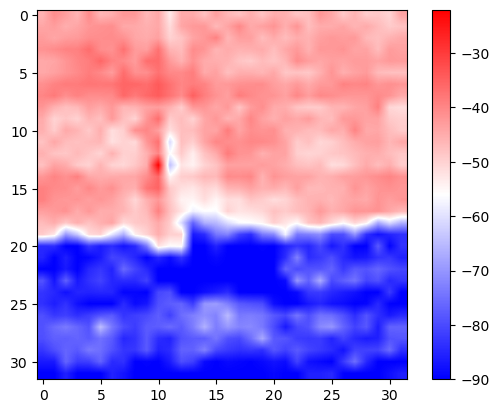

In [19]:
from matplotlib import pyplot as plt
plt.imshow(heat_map, cmap="bwr", interpolation="bilinear")
plt.colorbar()
plt.show()

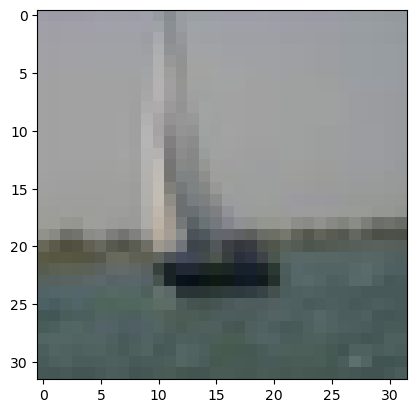

In [20]:
plt.imshow(explain_img)

In [ ]:
heat_map_basic = finite_differences_map(basic_res_net, 8, explain_img)

In [ ]:
plt.imshow(heat_map_basic, cmap="bwr", interpolation="bilinear")
plt.colorbar()
plt.show()

 50%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 8/16 [00:10<00:10,  1.31s/it]/tmp/ipykernel_31281/3137661496.py:15: RuntimeWarning: divide by zero encountered in divide
  finite_difference = np.clip(activation_diff/actual_diffs, -30, 30) # take absolute slope
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:21<00:00,  1.33s/it]


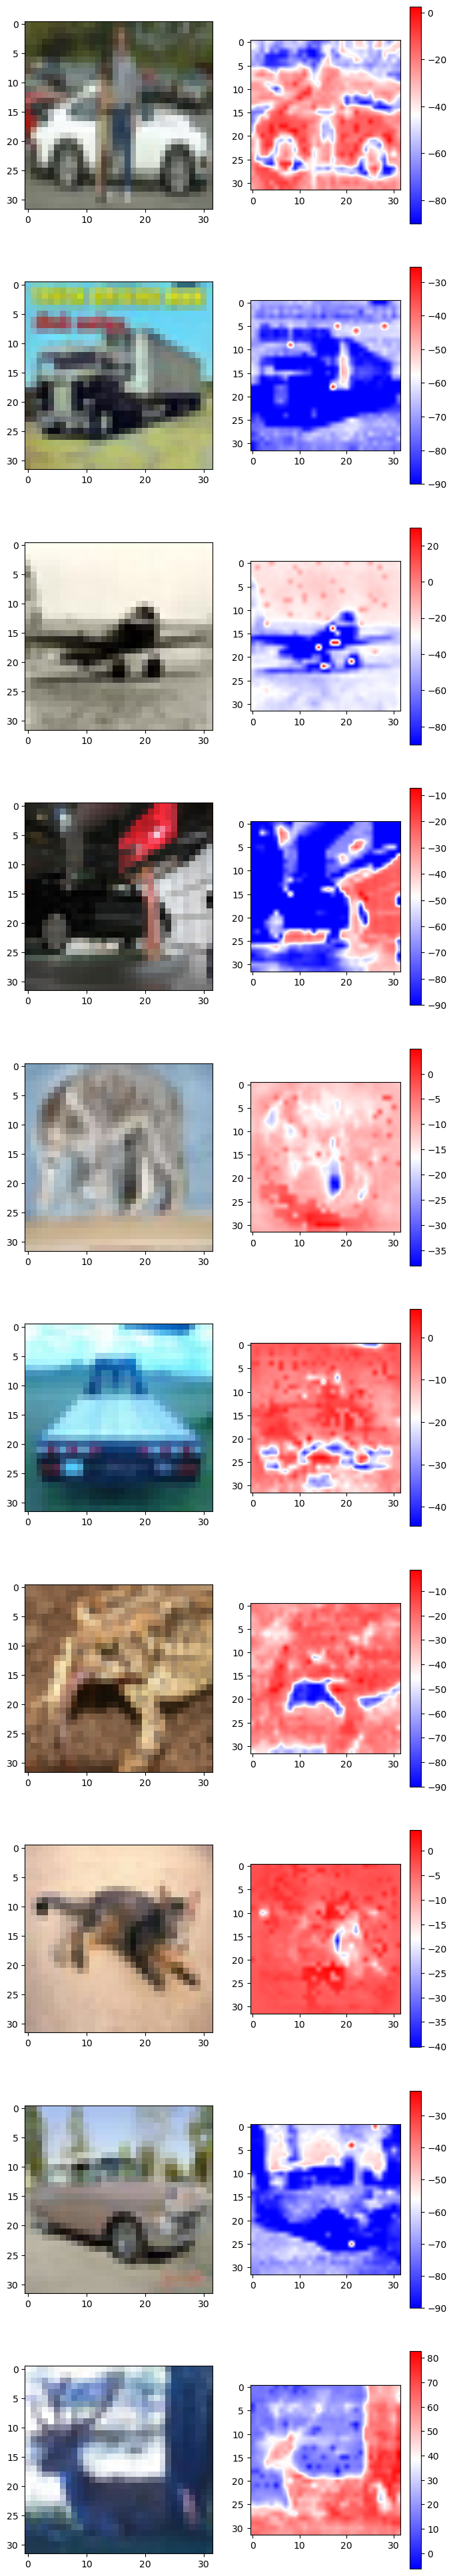

In [40]:
num_images = 10
random_images = np.random.choice(5000, (num_images), replace=False)
plt.figure(figsize=(8, 5*num_images))
for i, r in enumerate(random_images):
    target_class = valid.dataset.targets[r]
    explain_random_img = valid.dataset.data[r]
    random_heat_map = finite_differences_map(color_cnn, target_class, explain_random_img)
    plt.subplot(num_images, 2, 2*i+1)
    plt.imshow(explain_random_img)
    plt.subplot(num_images, 2, 2*i+2)
    plt.imshow(random_heat_map, cmap="bwr", interpolation="bilinear")
    plt.colorbar()
plt.show()
